# Тестовое задание

Требуется разработать алгоритм максимизации функции k на ориентированном мультиграфе (ССиТ).

Построение алгоритма будет выполняться в 2 этапа:
1. Написание движка для нахождения функции k на заданном ориентированном мультиграфе (ССиТ)
2. Оптимизация функции k

### Этап 1: Написание движка для нахождения функции k на заданном ориентированном мультиграфе

Код определяет классы для графа, состоящего из вершин и ребер, со специальными узлами для скважин и стока. Затем он создает граф, находит все ребра, которые соединяют скважины со стоком, и вычисляет дебиты через ребра в трубопроводе для скважин

Классы для графа включают класс Vertex, класс Edge и специальные классы Well и Drain, которые наследуются от класса Vertex. Класс Vertex имеет атрибут idx для хранения индекса вершины, атрибут edge_input для хранения списка входящих ребер и атрибут Q для хранения дебита вершины. Класс Edge имеет атрибут idx для хранения индекса ребра, а также атрибуты vertex1 и vertex2 для хранения вершин на обоих концах ребра. Классы Well и Drain имеют дополнительные атрибуты для хранения параметров дебита, специфичных для этих узлов

Функция create_graph() создает график, запрашивая у пользователя количество скважин (начальных вершин графа), промежуточных узлов (Vertex) и общее количество ребер, создавая экземпляры соответствующих классов для представления этих узлов и ребер. Ввод производится последовательно, в соответствии с направлением графа. Затем функция обновляет дебиты через вершины и ребра до тех пор, пока все ребра и узлы не обретут его значения.


Функция find_pipes() принимает узел скважины и список всех ребер на граф, и возвращает список всех ребер, которые соединяют скважину со стоком. Эта функция используется для нахождения суммы всех потерь на трубах от скважины до стока

Функция find_Q_well(p0) принимает значение давления на стоке и возвращает систему уравнений, которые будут использованы для решения и нахождения значения дебитов каждой скважины на графе

In [4]:
from sympy import symbols, Eq, solve

# Создание классов вершин и ребр графа. Скважины и сток будут особыми узлами с отдельными классами
class Well:
    def __init__(self, idx, alpha, const, Q):
        self.idx = idx
        self.alpha = alpha
        self.const = const
        self.Q = Q
          
class Vertex:
    def __init__(self, idx):
        self.idx = idx
        self.edge_input = []
        self.Q = 0

    def update_Q(self):
        self.Q = sum(edge.Q_edge for edge in self.edge_input)

class Edge:
    def __init__(self, idx, vertex1, vertex2, length = 5, diameter = 2, roughness = 0.1, density = 1000):
        self.idx = idx
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.length = length
        self.diameter = diameter
        self.roughness = roughness
        self.density = density
        self.update_Q_edge()

    def update_Q_edge(self):
        self.Q_edge = self.vertex1.Q
        self.pressure_loss = self.density * self.length * self.Q_edge * self.roughness / self.diameter

class Drain:
    def __init__(self, p_0, alpha = 3, const = 10, idx=0):
        self.p_0 = p_0
        self.edge_input = []
        self.alpha = alpha
        self.const = const
        self.idx = idx
        self.Q_0 = self.alpha * self.p_0 + self.const

In [5]:
# Создание графа
def create_graph():
    alpha = 3
    const = 5
    # Количество скважин
    num_wells = int(input("Enter the number of Wells: "))
    wells = []
    
    # Создание списка из num_wells элементов - Q1, Q2, Q3
    flow_rate = []
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(num_wells)])
    
    counter = 0
    for i in range(num_wells):
        counter = counter + 1
        wells.append(Well(i+1, alpha, const, flow_rate[i]))

    # Количество вершин
    num_vertex = int(input("Enter the number of Vertex: "))
    vertex = []
    for i in range(num_vertex):
        vertex.append(Vertex(i + counter))

    # Сток
    drain = [Drain(100)]
    common_vertex = drain + wells + vertex # A common array of all vertices
    print(common_vertex)

    # Количество ребр (труб)
    num_edges = int(input("Enter the number of Edges: "))
    edges = []
    for i in range(num_edges):
        vertex1 = int(input("Enter the first vertex for edge {}: ".format(i + 1)))
        vertex2 = int(input("Enter the second vertex for edge {}: ".format(i + 1)))
        # length = float(input("Enter the length for edge {}: ".format(i + 1)))
        # diameter = float(input("Enter the diameter for edge {}: ".format(i + 1)))
        # roughness = float(input("Enter the roughness for edge {}: ".format(i + 1)))
        # edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2], length, diameter, roughness))
        edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2]))

    for edge in edges:
        edge.vertex2.edge_input.append(edge)
        
    # Обновление характеристик дебитов на узлах и гранях, после создания всех элементов графа и их связей
    while edges[num_edges-1].Q_edge == 0:
        for edge in edges:
            edge.update_Q_edge()

        for vert in vertex:
            vert.update_Q()

    return wells, vertex, drain, edges, flow_rate

In [6]:
wells, vertex, drain, edges, flow_rate = create_graph()

[<__main__.Drain object at 0x000001B322FB3AC0>, <__main__.Well object at 0x000001B322F9A520>, <__main__.Well object at 0x000001B322FB3760>, <__main__.Vertex object at 0x000001B322FB36D0>, <__main__.Vertex object at 0x000001B322FB37F0>, <__main__.Vertex object at 0x000001B322FB3730>]


In [7]:
# Нахождение всех граней графа, ведущих от скважины до стока
def find_pipes(well, edges, drain):
    pipes = []
    visited = set()
    queue = []
    queue.append(well)
    while queue:
        curr = queue.pop(0)
        visited.add(curr)
        for edge in edges:
            if edge.vertex1 == curr and edge.vertex2 not in visited:
                queue.append(edge.vertex2)
                pipes.append(edge)
                if edge.vertex2 == drain:
                    return pipes
    return pipes

In [8]:
pipes_from_wells_to_drain = []
for well in wells:
    pipes_from_wells_to_drain.append(find_pipes(well, edges, drain[0]))

In [9]:
# Проверка дебита на последней заданной трубе
print(pipes_from_wells_to_drain[1][-1].Q_edge)

Q1 + Q2


In [10]:
alpha = drain[0].alpha
const = drain[0].const
p0 = drain[0].p_0

# Нахождение уравнений от-но дебитов каждой скважины
def find_Q_well(p0):
    p0 = p0
    Q_well = []
    for well in range(len(wells)):
        Q_well.append(alpha * (p0 + sum(edge.pressure_loss for edge in pipes_from_wells_to_drain[well])) + const)
    return Q_well

In [11]:
p0 = drain[0].p_0
Q0_prev = 0
eps = 0.001

# Итерационный поиск Q0
while True:

    Q_well = find_Q_well(p0)
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(len(Q_well))])

    # Решение системы уравнений от-но Q скважин
    eqs = [Eq(Q_well[i], flow_rate[i]) for i in range(len(Q_well))]
    sol = solve(eqs, flow_rate)

    # Нахождение нового Q0
    Q0 = sum(sol.get(well) for well in flow_rate)

    # Проверка сходимости
    if abs(Q0 - Q0_prev) < eps:
        break

    Q0_prev = Q0

    # Нахождение нового p0
    p0 = (Q0-const)/alpha

print("Q0:", Q0)
print("p0:", p0)

Q0: -9.19437649726549e-8
p0: -3.33328737677481


In [13]:
# Нахождение целевой функции
def find_k():
    k = Q0 - sum(edge.length*edge.diameter/edge.roughness for edge in edges)
    return k

k = find_k()
print("k function:", k)

k function: -500.000000091944


### Этап 2
1. дополните параметры труб (шероховатость, длину, диаметр)   +
2. индивидуальные параметры альфа и константа для каждой трубы +
3. график сходимости по итерациям
4. подобрать константы что бы числа были физичные

### Новое уравнение для лупингов:
1. пропорционально пропускной способности
2. функция потенциала проводимости, зависящая от потенциально возможного дебита

In [2]:
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve


# Создание классов вершин и ребр графа. Скважины и сток будут особыми узлами с отдельными классами
class Well:
    def __init__(self, idx, alpha, const, Q):
        self.idx = idx
        self.alpha = alpha
        self.const = const
        self.Q = Q
          
class Vertex:
    def __init__(self, idx):
        self.idx = idx
        self.edge_input = []
        self.Q = 0

    def update_Q(self):
        self.Q = sum(edge.Q_edge for edge in self.edge_input)

class Edge:
    def __init__(self, idx, vertex1, vertex2, length = 100, diameter = 1.5, roughness = 0.1, density = 1000):
    # def __init__(self, idx, vertex1, vertex2, length, diameter, roughness, density = 1000):
        self.idx = idx
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.length = length
        self.diameter = diameter
        self.roughness = roughness
        self.density = density
        self.update_Q_edge()

    def update_Q_edge(self):
        self.Q_edge = self.vertex1.Q
        self.pressure_loss = self.density * self.length * self.Q_edge * self.roughness / self.diameter

class Drain:
    def __init__(self, p_0, alpha, const, idx=0):
        self.p_0 = p_0
        self.edge_input = []
        self.alpha = alpha
        self.const = const
        self.idx = idx
        self.Q_0 = self.alpha * self.p_0 + self.const
        
# Создание графа
def create_graph():
    # alpha = 3
    # const = 5
    # Количество скважин
    num_wells = int(input("Enter the number of Wells: "))
    wells = []
    
    # Создание списка из num_wells элементов - Q1, Q2, Q3
    flow_rate = []
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(num_wells)])
    
    counter = 0
    for i in range(num_wells):
        counter = counter + 1
        alpha = int(input("Enter alpha for well {}: ".format(i + 1)))
        const = int(input("Enter const for well {}: ".format(i + 1)))
        wells.append(Well(i+1, alpha, const, flow_rate[i]))

    # Количество вершин
    num_vertex = int(input("Enter the number of Vertex: "))
    vertex = []
    for i in range(num_vertex):
        vertex.append(Vertex(i + counter))

    # Сток
    alpha = int(input("Enter alpha for Drain {}: ".format(i + 1)))
    const = int(input("Enter const for Drain {}: ".format(i + 1)))
    p_0 = 100
    drain = [Drain(p_0, alpha, const)]
    common_vertex = drain + wells + vertex # A common array of all vertices
    print(common_vertex)

    # Количество ребр (труб)
    num_edges = int(input("Enter the number of Edges: "))
    edges = []
    for i in range(num_edges):
        vertex1 = int(input("Enter the first vertex for edge {}: ".format(i + 1)))
        vertex2 = int(input("Enter the second vertex for edge {}: ".format(i + 1)))
        # length = float(input("Enter the length for edge {}: ".format(i + 1)))
        # diameter = float(input("Enter the diameter for edge {}: ".format(i + 1)))
        # roughness = float(input("Enter the roughness for edge {}: ".format(i + 1)))
        # edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2], length, diameter, roughness))
        edges.append(Edge(i+1, common_vertex[vertex1], common_vertex[vertex2]))

    for edge in edges:
        edge.vertex2.edge_input.append(edge)
        
    # Обновление характеристик дебитов на узлах и гранях, после создания всех элементов графа и их связей
    while edges[num_edges-1].Q_edge == 0:
        for edge in edges:
            edge.update_Q_edge()

        for vert in vertex:
            vert.update_Q()
    return wells, vertex, drain, edges, flow_rate

wells, vertex, drain, edges, flow_rate = create_graph()

# Нахождение всех граней графа, ведущих от скважины до стока
def find_pipes(well, edges, drain):
    pipes = []
    visited = set()
    queue = []
    queue.append(well)
    while queue:
        curr = queue.pop(0)
        visited.add(curr)
        for edge in edges:
            if edge.vertex1 == curr and edge.vertex2 not in visited:
                queue.append(edge.vertex2)
                pipes.append(edge)
                if edge.vertex2 == drain:
                    return pipes
    return pipes

pipes_from_wells_to_drain = []
for well in wells:
    pipes_from_wells_to_drain.append(find_pipes(well, edges, drain[0]))

[<__main__.Drain object at 0x000002895F84E7F0>, <__main__.Well object at 0x000002895F84E730>, <__main__.Well object at 0x000002895F84EAF0>, <__main__.Vertex object at 0x000002895F84E130>, <__main__.Vertex object at 0x000002895F84E430>, <__main__.Vertex object at 0x000002895F84EE20>]


In [3]:
# Проверка дебита на последней заданной трубе
print(pipes_from_wells_to_drain[1][-1].Q_edge)

Q1 + Q2


In [12]:
# Параметры alpha и const задаются непосредственно на скважинах, а не трубах !
p0 = drain[0].p_0

# Нахождение уравнений от-но дебитов каждой скважины
def find_Q_well(p0):
    p0 = p0
    Q_well = []
    for well in range(len(wells)):
        Q_well.append(wells[well].alpha * (p0 + sum(edge.pressure_loss for edge in pipes_from_wells_to_drain[well])) + wells[well].const)
    return Q_well


In [13]:
def find_Q_drain(p0):

    p0 = p0
    Q_well = find_Q_well(p0)
    flow_rate = symbols(['Q{}'.format(i+1) for i in range(len(Q_well))])

    # Решение системы уравнений от-но Q скважин
    eqs = [Eq(Q_well[i], flow_rate[i]) for i in range(len(Q_well))]
    sol = solve(eqs, flow_rate)

    # Нахождение нового Q0
    Q0 = sum(sol.get(well) for well in flow_rate)

    # Нахождение нового p0
    p0 = (Q0-const)/alpha
    return Q0, p0

In [15]:
# Итерационный поиск Q0
# while True:

#     Q_well = find_Q_well(p0)
#     flow_rate = symbols(['Q{}'.format(i+1) for i in range(len(Q_well))])

#     # Решение системы уравнений от-но Q скважин
#     eqs = [Eq(Q_well[i], flow_rate[i]) for i in range(len(Q_well))]
#     sol = solve(eqs, flow_rate)

#     # Нахождение нового Q0
#     Q0 = sum(sol.get(well) for well in flow_rate)

#     # Проверка сходимости
#     if abs(Q0 - Q0_prev) < eps:
#         break

#     Q0_prev = Q0

#     # Нахождение нового p0
#     p0 = (Q0-const)/alpha

Q0: -0.00201284861383477
p0: -1.57700049417746


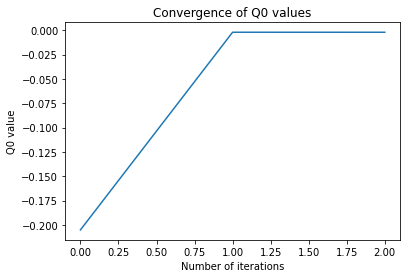

k function: -500.002012848614


In [14]:
alpha = drain[0].alpha
const = drain[0].const
Q0_prev = drain[0].Q_0
eps = 0.001

iterations = []
Q0_values = []

# set the maximum number of iterations
max_iterations = 100

i = 0
while i < max_iterations:
    Q0, p0 = find_Q_drain(p0)
    iterations.append(i)
    Q0_values.append(Q0)
    if abs(Q0 - Q0_prev) < eps:
        break

    Q0_prev = Q0

    # Нахождение нового p0
    p0 = (Q0-const)/alpha
    i += 1

print("Q0:", Q0)
print("p0:", p0)

plt.plot(iterations, Q0_values)
plt.xlabel('Number of iterations')
plt.ylabel('Q0 value')
plt.title('Convergence of Q0 values')
plt.show()


# Нахождение целевой функции
def find_k():
    k = Q0 - sum(edge.length * edge.diameter/edge.roughness for edge in edges)
    return k

k = find_k()
print("k function:", k)